In [20]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
CURRENT_DIR = os.getcwd()

# Set the root directory to the parent of the current directory
ROOT = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
sys.path.insert(0, ROOT)

from notebooks.plotting_tools import *
from code_.model_configs import model_cfg

In [21]:
RESULTS_PATH = os.path.join(ROOT,'results')

In [22]:
models_features_config = {
    'vit': {'multiplier': 196},
    'expansion': {'multiplier': 36},
    'fully_connected': {'multiplier': 36}
}

def load_and_prepare_data(model_name, multiplier, dataset, region):
    filepath = os.path.join(RESULTS_PATH, model_name + '_' + dataset + '_' + region + '.pkl')
    with open(filepath, 'rb') as file:
        df = pickle.load(file)
    df['model'] = model_name
    df['features'] = df['features'].apply(lambda x: int(x) * multiplier)
    df['score'] = df['score'].astype(np.float32)
    return df

# Main results

In [7]:
DATASET = 'majajhong' # one of ['majajhong', 'naturalscenes']
region = 'V4' # for majajhong: [V4,IT], for naturalscenes: [early visual stream, midventral visual stream, ventral visual stream]

In [29]:
# Process each model
all_dfs = []
for model_name, config in models_features_config.items():
    features_list = model_cfg[DATASET]['models'][model_name]['features']
    df_model = load_and_prepare_data(model_name, config['multiplier'], DATASET, region)
    all_dfs.append(df_model)

# Combine all dataframes and reset index
df = pd.concat(all_dfs).reset_index(drop=True)

In [30]:
# alexnet data
with open(os.path.join(RESULTS_PATH, 'alexnet' + '_' + DATASET + '_' + region + '.pkl'), 'rb') as file:
    df_alexnet = pickle.load(file)  

In [31]:
names ={'expansion':'Convolutional','vit':'Transformer','fully_connected':'Fully connected'}
palette ={'Convolutional':'royalblue','Transformer':'palevioletred','Fully connected':'darkviolet',
         'expansion_new':'red'}

df['model'] = df['model'].map(names)
df['color'] = df['model'].map(palette)

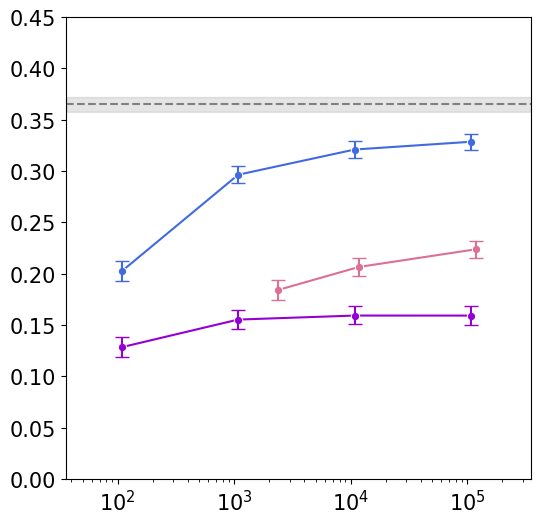

In [32]:
rcParams['figure.figsize'] = (6,6)  

# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='model', marker='o', palette = palette)
# adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])   
    
# alexnet 
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')

# adding 95% confidence interval 
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], df_alexnet['upper'], color='gray', alpha=0.2)

plt.ylim(0,0.45) if DATASET == 'naturalscenes' else plt.ylim(0,0.65)
plt.xlabel('')
plt.ylabel('')
plt.xlim(df['features'].min()/3,df['features'].max()*3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")        
ax1.legend(frameon=False,fontsize=12) if region == 'V4' else ax1.legend_.remove()
plt.savefig(os.path.join(ROOT, f'figures/figure_2_{DATASET}_{region}.png'), dpi=200) 
plt.show()

# Scaling effect

In [35]:
DATASET = 'naturalscenes'
regions = model_cfg[DATASET]['regions']

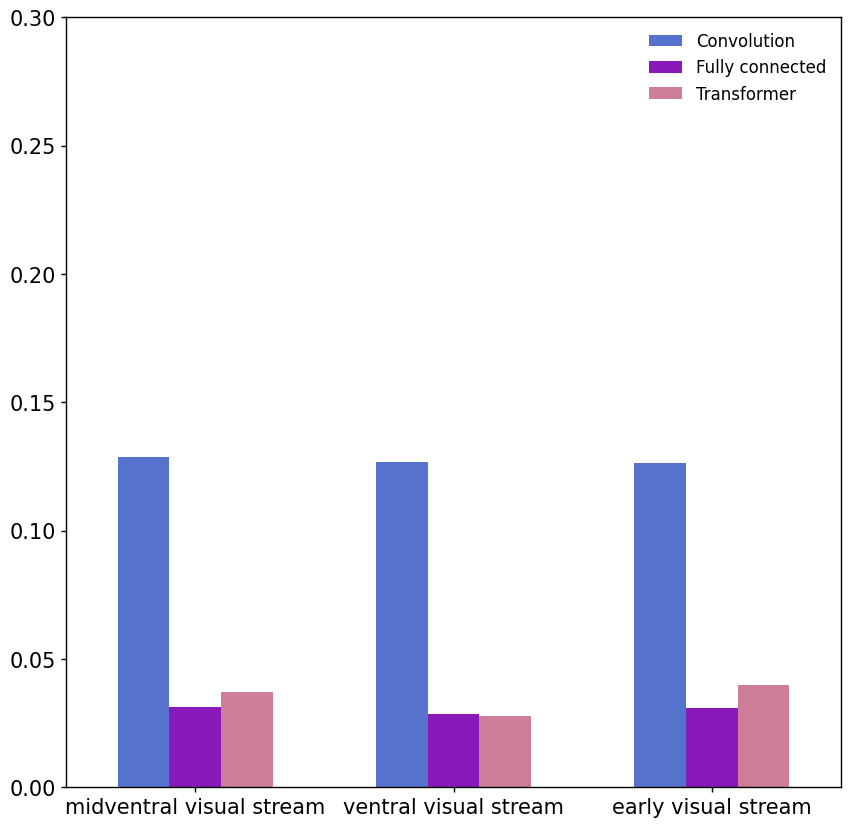

In [37]:
# Configurations for models and features
models_config = {
    'expansion': {'min_features': 108, 'max_features': 1080000},
    'fully_connected': {'min_features': 108, 'max_features': 1080000},
    'vit': {'min_features': 2352, 'max_features': 1176000}
}

# Dataset dependent changes
if DATASET == 'naturalscenes':
    models_config['expansion']['max_features']/=10 
    models_config['fully_connected']['max_features']/=10 
    models_config['vit']['max_features']/=10 

# Data initialization
ratios_dicts = {model: {'region':[], 'dataset':[], 'model':[], 'smallest model score':[], 'largest model score':[], 'difference':[]} for model in models_config}


# Loop through regions and models
for region in regions:
    for model_name, config in models_config.items():
        df_model = load_and_prepare_data(model_name, models_features_config[model_name]['multiplier'], DATASET, region)
        smallest_score = float(df_model[df_model.features == config['min_features']]['score'].item())
        largest_score = float(df_model[df_model.features == config['max_features']]['score'].item())
        
        ratios_dicts[model_name]['region'].append(region)
        ratios_dicts[model_name]['dataset'].append(DATASET)
        ratios_dicts[model_name]['model'].append(model_name)
        ratios_dicts[model_name]['smallest model score'].append(smallest_score)
        ratios_dicts[model_name]['largest model score'].append(largest_score)
        ratios_dicts[model_name]['difference'].append(largest_score - smallest_score)

# Concatenate all dataframes
df = pd.concat([pd.DataFrame.from_dict(ratios_dicts[model]) for model in models_config]).reset_index(drop=True)

# plot
df['model'] = df['model'].map({'expansion': 'Convolution', 'vit': 'Transformer', 'fully_connected': 'Fully connected'})
palette = {'Convolution': 'royalblue', 'Transformer': 'palevioletred', 'Fully connected': 'darkviolet'}

plt.figure(figsize=(10,10))
ax1 = sns.barplot(x='region', y='difference', hue='model', width=0.6, palette=palette, data=df)
plt.xlabel('')
plt.ylabel('')
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(0, 0.3 if DATASET == 'naturalscenes' else 0.45)
ax1.legend(frameon=False, fontsize=12)
for spine in ax1.spines.values():
    spine.set_linewidth(1)
ax1.xaxis.set_tick_params(width=1)
ax1.yaxis.set_tick_params(width=1)
plt.savefig(os.path.join(ROOT,f'figures/figure_2_scaling_effect_{DATASET}_{region}.png'), dpi=200)